What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [1]:
using Globtim
include("../src/lib_func.jl")

# Constants and Parameters
d = 4 # Initial Degree 
const n, a, b = 2, 10, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 3e-2             # Define the tolerance for the L2-norm

f = CrossInTray # Objective function

CrossInTray (generic function with 1 method)

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [32]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.5) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end

current L2-norm: 0.21877316208032133
Number of samples: 22
current L2-norm: 0.1377083991915426
Number of samples: 28
current L2-norm: 0.037779858002456146
Number of samples: 35
current L2-norm: 0.07998046709861971
Number of samples: 42
current L2-norm: 0.06967953221185019
Number of samples: 50
current L2-norm: 0.058192027377838344
Number of samples: 58
attained the desired L2-norm: 0.01906774261095705


We now expand the approximant computed in the tensorized Chebyshev basis into standard monomial basis.

In [33]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs) 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d)) # Convert coefficients to Float64 for homotopy continuation
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad);

Solve the system of partial derivatives using HomotopyContinuation. Note: restricted to Floats64 coefficients. 

In [34]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false);

Tracking 100 paths...   2%|▋                            |  ETA: 0:06:36



Tracking 100 paths... 100%|█████████████████████████████| Time: 0:00:08
  # paths tracked:                  100
  # non-singular solutions (real):  100 (86)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         100 (86)


Sort through the critical points, make sure they fall into the domain of definition. Make them into a Dataframe.

In [35]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z= h_z); # Create a DataFrame

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/georgy/.jlassetregistry.lock
└ @ Pidfile /home/georgy/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


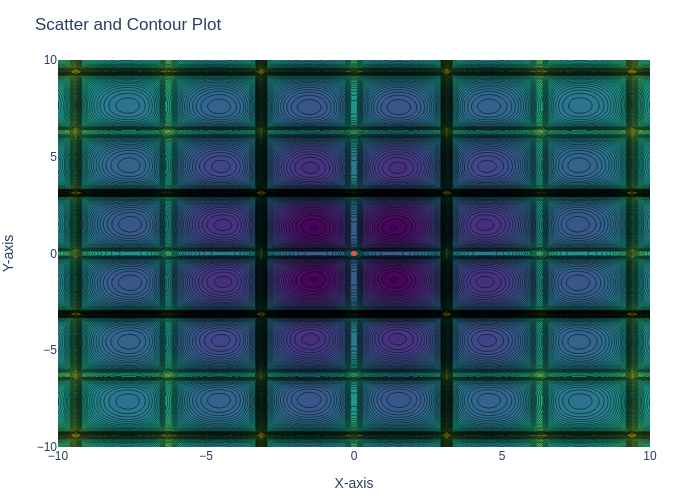

In [6]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 100  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]
# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=100, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="Scatter and Contour Plot",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)
# display(plot(all_traces, layout))

Size of the coordinates: (4624, 2)
Plotting 3D scatter plot


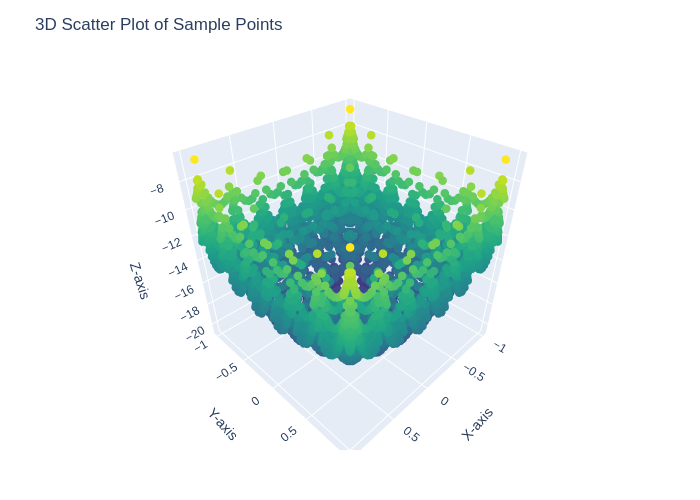

In [36]:
# Extract coordinates and function values
coords = poly_approx.grid
z_coords = poly_approx.z

println("Size of the coordinates: ", size(coords))

# Plot the 3D scatter plot if the dimensions are 2
if size(coords)[2] == 2
    track = scatter3d(
        x=coords[:, 1],
        y=coords[:, 2],
        z=z_coords,
        mode="markers",
        marker=attr(
            size=5,
            color=z_coords,
            colorscale="Viridis"
        )
    )
    println("Plotting 3D scatter plot")

    layout = Layout(
        title="3D Scatter Plot of Sample Points",
        scene=attr(
            xaxis=attr(title="X-axis"),
            yaxis=attr(title="Y-axis"),
            zaxis=attr(title="Z-axis")
        )
    )

    plt = plot([track], layout)
end
display(plt)

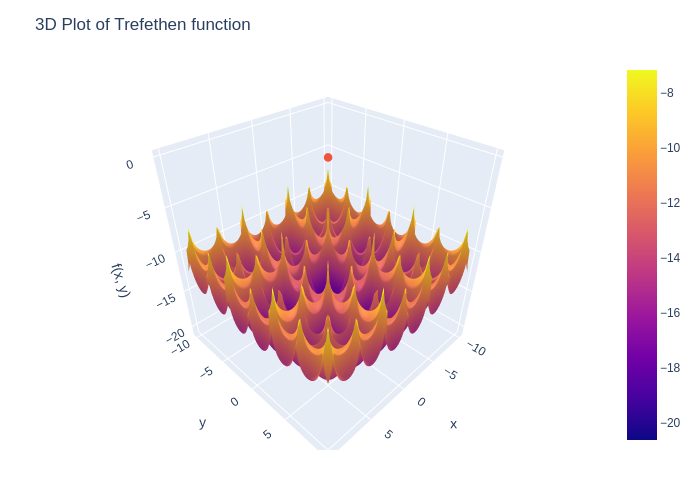

In [21]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of Trefethen function",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
        height=800
)
# Display the plot layout,
plt = plot([sf, crit_pts], layout)

In [22]:
# Save the plot as an HTML file to preserve the animation
# savefig(plt, "trefethen_function_plot.html")

### Now we repeat the same procedure with CrossInTray affected by some random noise (centered at 0).

In [23]:
# Define the noisy version of the objective function
function noisy_CrossInTray(xx::Vector{Float64}; mean::Float64=0.0, stddev::Float64=1.0)::Float64
    noise = rand(Normal(mean, stddev))
    return CrossInTray(xx) + noise
end


while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end


attained the desired L2-norm: 0.019715435624405662


In [25]:
using Clustering

# Assuming df is already defined and contains the columns x, y, z
data_matrix = transpose(Matrix(df[:, [:x, :y, :z]]))

print(data_matrix)

# Perform K-means clustering with k clusters
k = 3  # Number of clusters
result = kmeans(data_matrix, k)

println(result.centers)
# Add the cluster assignments to the DataFrame


# Display the DataFrame with cluster assignments
println(result.assignments)


[-1.3007463981658309e-15; -4.070935145078032e-15; -0.026021570276094558;;]

ArgumentError: ArgumentError: k must be from 1:n (n=1), k=3 given.